In [9]:
# Variables
# file_path_edges = './scifi/scifi_triples.txt'
# file_path_entities = './scifi/entity2id.txt'

# data from: https://github.com/thunlp/KB2E
file_path_train = '../data/FB15k/train.txt'
file_path_test = '../data/FB15k/test.txt'
file_path_entities = '../data/FB15k/entity2id.txt'
file_path_relations = '../data/FB15k/relation2id.txt'


embedding_size = 300
train_ratio = 0.7

batch_size = 100
epochs = 5

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
import numpy as np

In [45]:
# Visualize Results
import matplotlib.pyplot as plt

In [46]:
train_file = open(file_path_train, 'r')
test_file = open(file_path_test, 'r')
entities_file = open(file_path_entities, 'r')
relations_file = open(file_path_relations, 'r')

In [47]:
entity_map = dict((line.strip().split("\t") for line in entities_file))
relation_map = dict((line.strip().split("\t") for line in relations_file))

In [48]:
# Read edges
edges_train = {}
edges_test = {}
classes = set(range(relation_count))

In [49]:
entity_count, relation_count

(14951, 1345)

In [50]:
def extract_triples(file, skip_first = True):
    edges =  {}
    for line in file:
        if skip_first:
            skip_first = False
            continue

        data = line.strip().split("\t")
        head = int(entity_map[data[0]])
        rel = int(relation_map[data[2]])
        tail = int(entity_map[data[1]])
        edge = (head, tail)

        if rel not in classes:
            print("New relation type found")
        classes.add(rel)
        if edge not in edges.keys():
            edges[edge] = [rel]
        else:
            edges[edge].append(rel)
    return edges

In [51]:
edges_train = extract_triples(train_file)
edges_test = extract_triples(test_file)

In [52]:
len(edges_train), len(edges_test)

(394803, 57359)

In [53]:
# Preprocessing functions
def multi_hot(types):
    vec = np.zeros(len(classes))
    x = True
    for t in types:
        x = False
        vec[t] = 1
    if x:
        print(":(")
    return vec

def preprocess(pair, types):
    x = np.array([pair[0]] + [pair[1]])
    y = multi_hot(types)
    return x, y

In [54]:
def process_split(edges):
    # Preprocess data
    data_x = []
    data_y = []

    for key in edges.keys():
        x, y = preprocess(key, edges[key])
        data_x.append(x)
        data_y.append(y)
    
    return data_x, data_y

In [55]:
x_train, y_train = process_split(edges_train)
x_test, y_test = process_split(edges_test)

In [56]:
(len(x_train), len(x_test))

(394803, 57359)

In [57]:
classes_size = len(classes)
classes_size

1345

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=2))
model.add(GlobalAveragePooling1D())
model.add(Dense(classes_size))

NameError: name 'vocab_size' is not defined

In [58]:
epochs

5

In [59]:
training_distribution = np.sum(y_train.astype(np.float), axis=0)

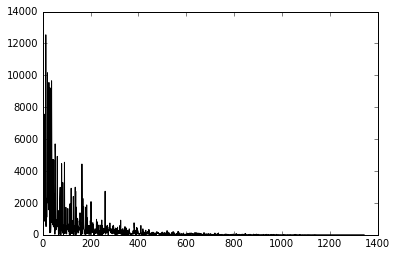

In [60]:
plt.plot(training_distribution, color='black')

In [12]:
early_stopping = EarlyStopping(monitor='categorical_accuracy', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)

In [61]:
# Training the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=batch_size)

Epoch 1/5
304293/304293 [==============================] - 116s 381us/step - loss: 12.8427 - categorical_accuracy: 0.1616
Epoch 2/5
304293/304293 [==============================] - 112s 369us/step - loss: 12.1728 - categorical_accuracy: 0.1934
Epoch 3/5
304293/304293 [==============================] - 121s 399us/step - loss: 11.8653 - categorical_accuracy: 0.2061
Epoch 4/5
304293/304293 [==============================] - 121s 397us/step - loss: 11.5774 - categorical_accuracy: 0.2174
Epoch 5/5
304293/304293 [==============================] - 116s 381us/step - loss: 11.2799 - categorical_accuracy: 0.2297


In [62]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
score

130412/130412 [==============================] - 3s 24us/step


[11.184379205021306, 0.22928104764413595]

In [63]:
y_predicted = np.around(model.predict(x_test))

In [64]:
expected = np.sum(y_test.astype(np.float), axis=0)
actual = np.sum(y_predicted, axis=0)
actual[actual < 0] = 0

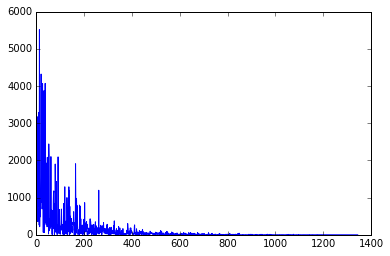

In [65]:
plt.plot(expected)

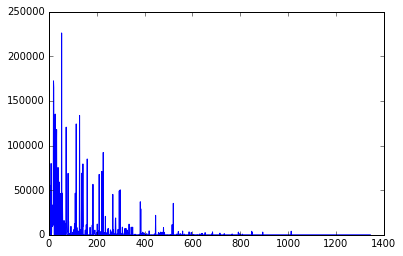

In [66]:
plt.plot(actual)

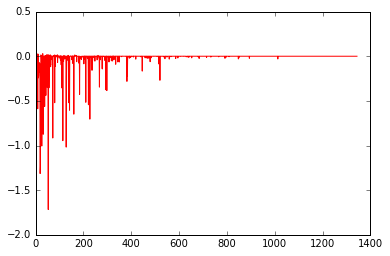

In [67]:
plt.plot((expected - actual)/y_test.shape[0], color='r')

In [ ]:
# Baseline Model
def model(features, labels, mode, params, config):
    bow_input = tf.reduce_mean(tf.one_hot(features, vocab_size), 1) # tf.placeholder(tf.float32, shape=(None, vocab_size), name="x")
    label = labels # tf.placeholder(tf.float32, shape=(None, classes_size), name="y")
    embedding = tf.Variable(tf.random_normal([embedding_size, vocab_size], stddev=0.1), name="embedding")
    parameters = tf.Variable(tf.random_normal([classes_size, embedding_size], stddev=0.1), name="weights")
    
    prediction = tf.nn.softmax(
                            tf.matmul(parameters,
                                        tf.matmul(embedding, bow_input)))
    
    loss = -1 * tf.reduce_sum(
        tf.matmul(label,
                    tf.log(prediction)))
    
    optimizer = AdamOptimizer()
    
    return tf.estimator.EstimatorSpec(mode, predictions=prediction, loss=loss, train_op=optimizer.minimize(loss))